#Tìm độ chêch lệch trên trục dữ liệu
Thống kê trong 1 ngày, tần số (Frequency) và lần mua gần nhất số lượng bao nhiêu (Recency) và số tiền thu nhập (Monetary) theo khách hàng.

In [5]:
import pandas as pd
import datetime as dt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


import plotly.graph_objs as go

data = pd.read_csv('/content/drive/MyDrive/python_OP/dataset_model.csv', encoding = 'unicode_escape')

print(data.shape)

(396532, 16)


In [6]:
#tính lần mua gần nhất

data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Tính toán các yếu tố trong mô hình RFM
data['TotalAmount'] = data['UnitPrice']*data['Quantity']

Latest_date = dt.datetime(2011,12,10)
RFM_data = data.groupby('CustomerID').agg({'InvoiceDate' : lambda x :(Latest_date - x.max()).days,
                                          'InvoiceNo' : 'count','TotalAmount' : 'sum'}).reset_index()

RFM_data.rename(columns = {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : "Frequency",
                          'TotalAmount' : "Monetary"},inplace = True)
RFM_data

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,182,4310.00
1,12348.0,75,31,1797.24
2,12349.0,18,73,1757.55
3,12350.0,310,17,334.40
4,12352.0,36,85,2506.04
...,...,...,...,...
4234,18280.0,277,10,180.60
4235,18281.0,180,7,80.82
4236,18282.0,7,12,178.05
4237,18283.0,3,754,2090.43


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



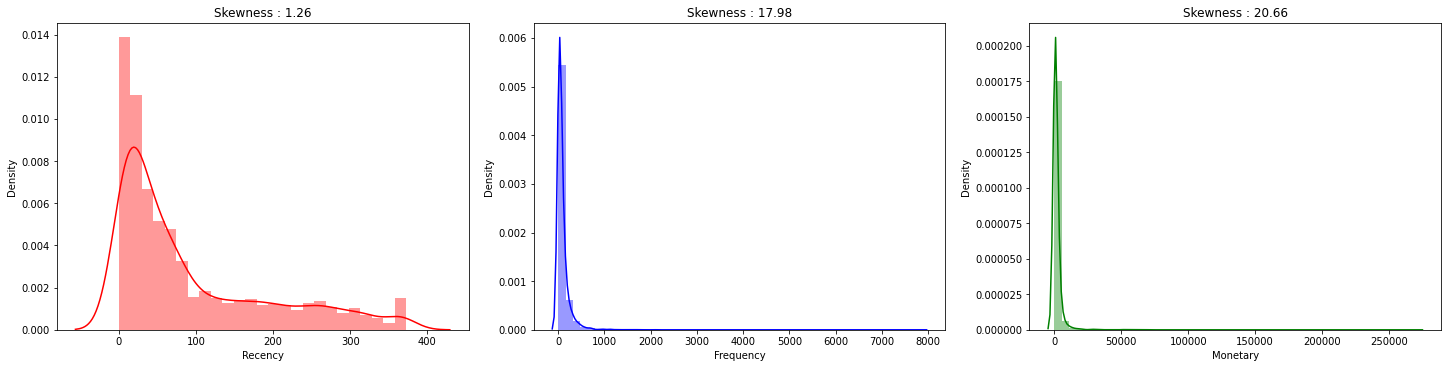

In [9]:
#Trực quan phân phối Recency, Frequency and Monetary.
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(RFM_data.columns[1:4]):
    plt.subplot(gs[0,i])
    sns.distplot(RFM_data[var],color= col[i])
    plt.title('Skewness ' + ': ' + round(RFM_data[var].skew(),2).astype(str))
    i= i+1

In [10]:
quantiles = RFM_data.quantile(q = [0.25,0.5,0.75])
quantiles.to_dict()

{'CustomerID': {0.25: 13810.5, 0.5: 15279.0, 0.75: 16767.5},
 'Frequency': {0.25: 18.0, 0.5: 42.0, 0.75: 102.0},
 'Monetary': {0.25: 308.84000000000003,
  0.5: 674.5199999999999,
  0.75: 1628.6200000000008},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.0}}

In [11]:
def R_score(var,p,d):
    if var <= d[p][0.25]:
        return 1
    elif var <= d[p][0.50]:
        return 2
    elif var <= d[p][0.75]:
        return 3
    else:
        return 4
#[2] Frequency and Monetary (Positive Impact : Higher the value, better the customer)
def FM_score(var,p,d):
    if var <= d[p][0.25]:
        return 4
    elif var <= d[p][0.50]:
        return 3
    elif var <= d[p][0.75]:
        return 2
    else:
        return 1

In [12]:
RFM_data['R_score'] = RFM_data['Recency'].apply(R_score,args = ('Recency',quantiles,))
RFM_data['F_score'] = RFM_data['Frequency'].apply(FM_score,args = ('Frequency',quantiles,))
RFM_data['M_score'] = RFM_data['Monetary'].apply(FM_score,args = ('Monetary',quantiles,))
RFM_data.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score
0,12347.0,2,182,4310.00,1,1,1
1,12348.0,75,31,1797.24,3,3,1
2,12349.0,18,73,1757.55,2,2,1
3,12350.0,310,17,334.40,4,4,3
4,12352.0,36,85,2506.04,2,2,1


In [13]:
#Now we will create : RFMGroup and RFMScore
RFM_data['RFM_Group'] = RFM_data['R_score'].astype(str) + RFM_data['F_score'].astype(str) + RFM_data['M_score'].astype(str)

#Score
RFM_data['RFM_Score'] = RFM_data[['R_score','F_score','M_score']].sum(axis = 1)
RFM_data.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Group,RFM_Score
0,12347.0,2,182,4310.00,1,1,1,111,3
1,12348.0,75,31,1797.24,3,3,1,331,7
2,12349.0,18,73,1757.55,2,2,1,221,5
3,12350.0,310,17,334.40,4,4,3,443,11
4,12352.0,36,85,2506.04,2,2,1,221,5


In [14]:
#Creating the Customer segments/ Loyality_level
loyalty_level = ['True Lover','Flirting','Potential lover','Platonic Friend']
cuts = pd.qcut(RFM_data['RFM_Score'],q = 4,labels=loyalty_level)
RFM_data['RFM_Loyality_level'] = cuts.values
RFM_data.tail(15)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Group,RFM_Score,RFM_Loyality_level
4224,18262.0,140,13,149.48,3,4,4,344,11,Platonic Friend
4225,18263.0,25,61,1213.16,2,2,2,222,6,Flirting
4226,18265.0,72,46,801.51,3,2,2,322,7,Flirting
4227,18269.0,366,7,168.60,4,4,4,444,12,Platonic Friend
4228,18270.0,38,11,283.15,2,4,4,244,10,Potential lover
4229,18272.0,2,166,3078.58,1,1,1,111,3,True Lover
4230,18274.0,30,11,175.92,2,4,4,244,10,Potential lover
4231,18276.0,43,14,335.86,2,4,3,243,9,Potential lover
4232,18277.0,58,8,110.38,3,4,4,344,11,Platonic Friend
4233,18278.0,73,9,173.90,3,4,4,344,11,Platonic Friend


In [15]:
fig = px.scatter(RFM_data,x = "Recency", y = "Frequency",color = "RFM_Loyality_level")
fig.show()

# Frequency V/s Monetary
fig = px.scatter(RFM_data,x = "Monetary", y = "Frequency",color = "RFM_Loyality_level")
fig.show()

# Monetary V/s Recency
fig = px.scatter(RFM_data,x = "Monetary", y = "Recency",color = "RFM_Loyality_level")
fig.show()

In [16]:
def right_treat(var):
    if var <= 0:
        return 1
    else:
        return var

# Describing the data
RFM_data.describe()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
count,4239.000000,4239.000000,4239.000000,4239.000000,4239.000000,4239.000000,4239.000000,4239.000000
mean,15289.066761,91.692852,93.543760,1964.023094,2.495164,2.506487,2.500118,7.501769
std,1718.757878,99.688631,230.625413,8335.006464,1.118050,1.117619,1.118271,2.816126
min,12347.000000,0.000000,2.000000,2.900000,1.000000,1.000000,1.000000,3.000000
25%,13810.500000,17.000000,18.000000,308.840000,1.000000,2.000000,1.500000,5.000000
50%,15279.000000,50.000000,42.000000,674.520000,2.000000,3.000000,3.000000,8.000000
75%,16767.500000,141.000000,102.000000,1628.620000,3.000000,4.000000,3.500000,10.000000
max,18287.000000,373.000000,7840.000000,270287.500000,4.000000,4.000000,4.000000,12.000000


In [17]:
#Applying on the data.
RFM_data['Recency'] = RFM_data['Recency'].apply(lambda x : right_treat(x))
RFM_data['Monetary'] = RFM_data['Monetary'].apply(lambda x : right_treat(x))

#Checking the Skewness of R, F and M
print('Recency Skewness : ' + RFM_data['Recency'].skew().astype(str))
print('Frequency Skewness : ' + RFM_data['Frequency'].skew().astype(str))
print('Monetary Skewness : ' + RFM_data['Monetary'].skew().astype(str))

Recency Skewness : 1.2578896378884323
Frequency Skewness : 17.977687113494753
Monetary Skewness : 20.657393220667444


In [19]:
import numpy as np
log_RFM_data = RFM_data[['Recency','Frequency','Monetary']].apply(np.log,axis = 1).round(4)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



,Recency,Frequency,Monetary
count,4239.000000,4239.000000,4239.000000
mean,3.737734,3.750115,6.597104
std,1.468903,1.241810,1.232680
min,0.000000,0.693100,1.064700
25%,2.833200,2.890400,5.732800
50%,3.912000,3.737700,6.514000
75%,4.948800,4.625000,7.395500
max,5.921600,8.967000,12.507200


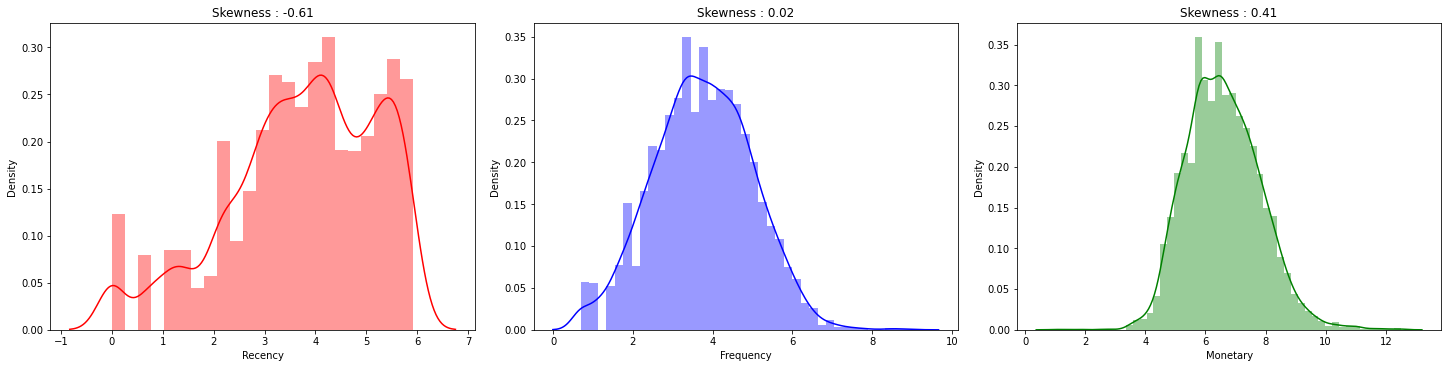

In [20]:
#Plot after transformation for the distributions :
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(log_RFM_data.columns[0:3]):
    plt.subplot(gs[0,i])
    sns.distplot(log_RFM_data[var],color= col[i])
    plt.title('Skewness ' + ': ' + round(log_RFM_data[var].skew(),2).astype(str))
    i= i+1
log_RFM_data.describe()

In [23]:
#Scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ss = StandardScaler()
Scaled_RFM_data = ss.fit_transform(log_RFM_data)
Scaled_RFM_data = pd.DataFrame(Scaled_RFM_data,columns=log_RFM_data.columns,index=log_RFM_data.index)

In [24]:
# Will search the optimal number of cluster based on the Elbow Method as below:
SS_distance = {}
for k in range(1,20):
    mod = KMeans(n_clusters= k, max_iter=1000,init = 'k-means++')
    mod = mod.fit(Scaled_RFM_data)
    SS_distance[k] = mod.inertia_

Text(0.5, 1.0, 'Elbow Techinque to find the optimal cluster size')

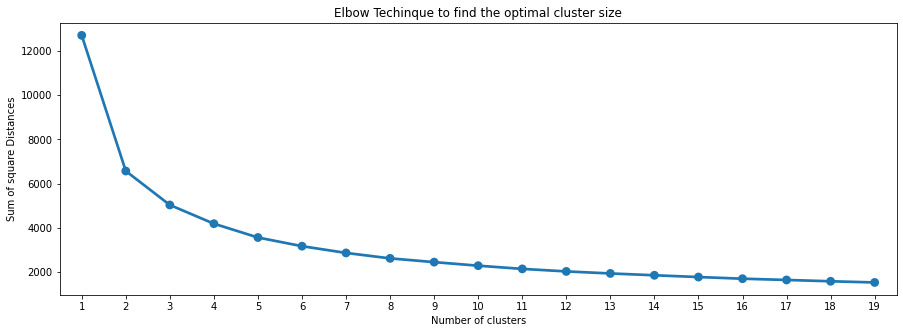

In [25]:
#Plotting the sum of square distance values and numbers of clusters
plt.figure(figsize = (15,5))
sns.pointplot(x = list(SS_distance.keys()), y = list(SS_distance.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of square Distances")
plt.title("Elbow Techinque to find the optimal cluster size")